<a href="https://colab.research.google.com/github/mathena828/GAN_Fashion-MNIST/blob/main/DCGAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!pip install -q imageio
!pip install -q git+https://github.com/tensorflow/docs

     |████████████████████████████████| 1.0MB 5.8MB/s 


In [4]:
# Import libraries.
import os
import PIL
import glob
import time
import imageio
import numpy as np
import tensorflow as tf
from IPython import display
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from keras.preprocessing import image
import tensorflow_docs.vis.embed as embed

In [5]:
# Download the Fashion MNIST dataset.
(train_images, train_labels), (test_images, test_labels) =  tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [6]:
# Pre-process the 60,000 training set images.
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32') # Convert pixels to floating point values. 
train_images = (train_images - 127.5) / 127.5 # Normalize the pixel values to be in the range of [-1,1].

In [7]:
# Perform hyperparameter optimization.
BUFFER_SIZE = 60000
BATCH_SIZE = 256
EPOCHS = 50 
NOISE_DIM = 100
EXAMPLES = 16
# Define a random seed value that will be used to produce images.
seed = tf.random.normal([EXAMPLES, NOISE_DIM])

In [8]:
# Shuffle then batch the dataset.
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [9]:
# Define the generator.
def build_generator():
    model = tf.keras.Sequential() # Initialize a sequential model object.
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,))) # Add a densely connected neural network layer.
    # Batch Normalization is used to scale the mean and variances of the layer's inputs.
    model.add(layers.BatchNormalization())
    # Leaky Rectified Linear Units are used to increase the range of the ReLu function.
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) 
    # Add a series of transposed convolution layers.
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1) # Upsample until the target shape (None,28,28,1), where None is the batch size, is reached.
    return model

In [10]:
# Build the generator.
generator = build_generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

In [11]:
# Define the discriminator.
def build_discriminator():
    model = tf.keras.Sequential() # Initialize a sequential model object.
    # Create a CNN-based image classifier.
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    # Add a droupout to prevent overfitting.
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    # Flatten the output of the last convolutional layer and pass it to the dense layer.
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model 

In [12]:
# Build the discriminator.
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [13]:
# Define a helper fucntion to calculate the cross entropy loss.
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# Measure how well the discriminator can distinguish real (1) from fake (0) images.
def discriminator_loss(real, fake):
    real_loss = cross_entropy(tf.ones_like(real), real) # Compare the binary predictions of the discriminator on real images to a tensor of all ones with the same shape.
    fake_loss = cross_entropy(tf.zeros_like(fake), fake) # Compare the binary predictions of the discriminator on fake images to a tensor of all zeroes with the same shape.
    total_loss = real_loss + fake_loss
    return total_loss
# Measure how well the generator can trick the discriminator.
def generator_loss(fake):
    return cross_entropy(tf.ones_like(fake), fake) # Compare the binary predictions of the discriminator on fake images to a tensor of all ones with the same shape.

In [14]:
# Define two seperate Adam optimizers for the generator and discriminator.
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [15]:
# Save checkpoints during training so the model can be restored.
checkpoint_dir = '/content/gdrive/My Drive/Fashion Synthesis/DCGAN/MNIST'
checkpoint_prefix = os.path.join(checkpoint_dir, "checkpoint")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer, discriminator_optimizer=discriminator_optimizer, generator=generator, discriminator=discriminator)

In [16]:
# Define a method to generate and save fake images after training. 
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(4,4))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [17]:
# Define a method that will return an image from a specific epoch.
def display_image(epoch):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch))

In [18]:
@tf.function # Compile the function into a callable TensorFlow graph.
def train_step(images):
    # Generate an image from some random noise.
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)
    # The discriminator classifies the real images from the training set and the fake images produced by the discriminator.
      real = discriminator(images, training=True)
      fake= discriminator(generated_images, training=True)
    # Calculate the losses of the generator and the discriminator. 
      gen_loss = generator_loss(fake)
      disc_loss = discriminator_loss(real, fake)
    # Calculate the gradients of the loss functions with GradientTape.
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    # Apply the optimizers to find the weights that minimize the losses. Update the generator and discriminator accordingly.
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [19]:
# Iterate over the number of epochs and train the DCGAN on the dataset in batches.
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time() # Get the starting time of each epoch.
    for image_batch in dataset:
      train_step(image_batch)
    # Produce images for each training step.
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, seed)
    # Save the model every 10 epochs.
    if (epoch + 1) % 10 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    print ('Time for epoch {} is {} seconds.'.format(epoch + 1, time.time()-start)) # Record how long it took for each epoch to run.
  # Produce an image for the final epoch.
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

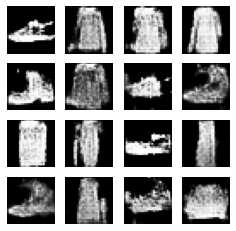

Time for epoch 2 is 719.6506066322327 seconds.


In [ ]:
# Train the generator and discriminator simultaneously.
train(train_dataset, EPOCHS)

In [20]:
# Restore training from the latest saved checkpoint.
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# Create a gif using all the saved images.
gif_file = 'dcgan_fashion_mnist.gif'
with imageio.get_writer(gif_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)
embed.embed_file(gif_file)